- This notebook contains experiments for the MovieLen_20M Dataset for the following models:

- **Updated PSI**

- **Regular PSI**

- **Pure SVD**

- **Most Pop**

- **Rand Rec**

In [ ]:
import os                                  #Hello2021
os.environ["OMP_NUM_THREADS"] = "8"        #"export" OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8"   #"export" OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "8"        #"export" MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" #"export" VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "8"    #Hello2021

## Imports

In [ ]:
import io
import os
import gzip
import json
import scipy
import random
import warnings
import numpy as np
import numba as nb
import pandas as pd
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as st
from collections import OrderedDict
import scipy.sparse as sparse
from scipy.linalg import orth
import matplotlib.pyplot as plt
from numpy import linalg as lin
import implicit
import pickle
warnings.filterwarnings('ignore')
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from datetime import datetime as dt_dt
from scipy.sparse.linalg import spsolve
from numpy.linalg import qr as QR_decomp
from scipy.sparse import csr_matrix, find
from pandas.api.types import CategoricalDtype
from typing import List
import torch
import torch.nn.functional as F
from torch import nn
from polara.evaluation.pipelines import random_grid
import bottleneck as bn

## Functions

In [ ]:
import sys
sys.path.append('/home/oolaleke/incremental_PSI/Scripts/')
#sys.path.append('/content/')

In [ ]:
import a_DataHelpers
import b_AlgoFunctions
import c_PredEval
import d_CorrScores
import e_VAEfunction

In [ ]:
from a_DataHelpers import getPivotMonths,Time_DataSplit,TestTrain_DataSplit,SingleRatingMatrix
from a_DataHelpers import AllRatingMatrices,All_SingleStepRatMat,psiStep_RatMat,psiAllStep_RatMat
from a_DataHelpers import Find_NewUsersItems,adjustedPSI_DF,adjustedAllDF,get_NEWHoldout,ADJUST_mainDF
from a_DataHelpers import  SingleStepRatMat_2,AllSingleStepRatMat_2

from b_AlgoFunctions import integrator,getStartingValues,integratorOnMat,last_psiTrainMat, pureSVD
from b_AlgoFunctions import Updt_RowMatrix,getRow_Mat,row_update, Updt_ColMatrix,getCol_Mat,colunm_update
from b_AlgoFunctions import UsersItems_RatPair,getRowCol_psiupdt,ITEMS_defferredStatus,USERS_defferredStatus
from b_AlgoFunctions import getV_listUpdate, SingleStep_UPDATE,ALLSTEPs_UPDATE, auc_score,TrainTest
from b_AlgoFunctions import mean_auc,tune_ALS,nonzeros,least_squares_cg,alternating_least_squares_cg

from c_PredEval import TopNPred,TQDMgetALLTopNPred, Hitrate_Eval,getAll_HitRate,mean_confidence_interval
from c_PredEval import TQDMgetALLTopNPred_ALLUSERS,getALLTopNPred_ALLUSERS,get_ALLRandPred
from c_PredEval import topN_Index,getAll_RandomHitRate,getMOSTPOP_Pred,getAll_MostPOPHitRate,getAll_MOSTPOP_Pred
from c_PredEval import StepCoverage_Ratio,AllSteps_Coverage_Ratio,getAll_VAEMRR, MRR_Eval,getAll_MRR_Eval
from c_PredEval import TQDMgetAll_MRR_Eval, getAll_MostPOP_MRR,getAll_RandomRecMRR, ials_TopNPred,ials_getALLPred
from c_PredEval import ials_getALLPredTQDM,ials_ALLUSERSpred,ialsALLPred_ALLUSERS,TQDM_ialsALLPred_ALLUSERS

from d_CorrScores import no_copy_csr_matrix,build_rank_weights_matrix,rank_weighted_jaccard_index
from d_CorrScores import Updt_getAll_AvgCorr, updtCorr_4AllRanks

from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat


In [ ]:
#######################################################################
def SingleStepRatMat_2(DF,U,V,user_column,item_column):  ##rows_ = n_users,cols_ = n_items
    rows_ = U.shape[0]
    cols_ = V.shape[0] 
    
    rows0 = DF[user_column].values
    cols0 = DF[item_column].values
    data  = np.broadcast_to(1., DF.shape[0]) # ignore ratings

    A0_Rating_matrix = coo_matrix((data, (rows0, cols0)), shape=(rows_, cols_)).tocsr()
    if A0_Rating_matrix.nnz < len(data):
        A0_Rating_matrix = A0_Rating_matrix._with_data(np.broadcast_to(1., A0_Rating_matrix.nnz), copy=False)

    return A0_Rating_matrix

def AllSingleStepRatMat_2(DFList,Ulist,Vlist,user_column,item_column):
    Rating_matrix_list = []
    for DF,U,V, in zip(DFList,Ulist,Vlist):
        df_Mat = SingleStepRatMat_2(DF,U,V,user_column,item_column)
        Rating_matrix_list.append(df_Mat)
    return Rating_matrix_list              


## Apply Functions on *MovieLenDF*

# Data Preparation

In [ ]:
#MLDF_20M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/newIncreMLDF_20M.csv.zip') 
MLDF_20M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/MLDF_20M.csv.zip') 
MLDF_20M['timestamp'] = pd.to_datetime(MLDF_20M['timestamp']) 
print(MLDF_20M.shape)   #
print(MLDF_20M.dtypes)
MLDF_20M

(9990682, 7)
userid                   int64
movieId                  int64
rating                   int64
timestamp       datetime64[ns]
timestamp_YM            object
userId                   int64
productId                int64
dtype: object


,userid,movieId,rating,timestamp,timestamp_YM,userId,productId
0,28507,1176,1,1995-01-09 11:46:44,1995-01,0,0
1,131160,47,1,1995-01-09 11:46:49,1995-01,1,1
2,85252,70,1,1996-01-29 00:00:00,1996-01,2,2
3,134445,45,1,1996-01-29 00:00:00,1996-01,3,3
4,99851,10,1,1996-01-29 00:00:00,1996-01,4,4
...,...,...,...,...,...,...,...
9990677,57814,3527,1,2015-03-31 05:44:17,2015-03,136366,3314
9990678,57814,48774,1,2015-03-31 05:44:23,2015-03,136366,9045
9990679,57814,1240,1,2015-03-31 05:50:01,2015-03,136366,1073
9990680,57814,2311,1,2015-03-31 05:51:23,2015-03,136366,2129


In [ ]:
print(MLDF_20M.shape)
print("For users: ")
print(MLDF_20M['userId'].nunique())
print(MLDF_20M['userId'].max())
print()
print("For items: ")
print(MLDF_20M['productId'].nunique())
print(MLDF_20M['productId'].max())
print()
print("Timestamp")
print(MLDF_20M['timestamp'].min())
print(MLDF_20M['timestamp'].max())

(9990682, 7)
For users: 
136677
136676

For items: 
20720
20719

Timestamp
1995-01-09 11:46:44
2015-03-31 06:11:28


In [ ]:
nunsers = MLDF_20M['userId'].nunique()
nitems = MLDF_20M['productId'].nunique()
print("Num of unique users: ",nunsers)
print("Num of unique items: ",nitems)
print()
sparsity = (1. * MLDF_20M.shape[0]) / (nunsers * nitems)
print("After filtering, there are %d inyteractions from %d users and %d items (sparsity: %.3f%%)" % 
      (MLDF_20M.shape[0], nunsers, nitems, sparsity * 100))

Num of unique users:  136677
Num of unique items:  20720

After filtering, there are 9990682 inyteractions from 136677 users and 20720 items (sparsity: 0.353%)


**Data Split**

In [ ]:
print("Size of Dataset: ", MLDF_20M.shape)
print('Min Date: ', MLDF_20M['timestamp'].min())
print("Max Date: ",MLDF_20M['timestamp'].max())

Size of Dataset:  (9990682, 7)
Min Date:  1995-01-09 11:46:44
Max Date:  2015-03-31 06:11:28


In [ ]:
train_df = MLDF_20M[MLDF_20M['timestamp_YM'] < '2010-01']    #'2016-02
print("DF Shape: ",train_df['userId'].shape)  ##63%
print("NUsers  : ",train_df['userId'].nunique())
print("max Ids  : ",train_df['userId'].max(),train_df['productId'].max())

DF Shape:  (8066566,)
NUsers  :  112109
max Ids  :  112108 12063


In [ ]:
remainder_df = MLDF_20M[MLDF_20M['timestamp_YM'] >= '2010-01']  
print("DF Shape: ",remainder_df['userId'].shape)  ##63%
print("NUsers  : ",remainder_df['userId'].nunique())
#print("max Ids  : ",remainder_df['userId'].min(),remainder_df['productId'].min())

DF Shape:  (1924116,)
NUsers  :  30094


In [ ]:
n = 80200  #num_of_interaction/no_steps
all_df = []
for g, df in remainder_df.groupby(np.arange(len(remainder_df)) // n):
    all_df.append(df)
    print(df['userId'].nunique())
print()
print(g+1)    

3322
3482
3194
3142
3224
3536
3559
3263
3562
3459
3311
3124
3115
3165
3098
3169
3129
3192
3409
3267
3077
2772
2644
2730

24


In [ ]:
for i in range(5):
    print(all_df[i]['timestamp'].min()) 
    print(all_df[i]['timestamp'].max())
    print()

2010-01-01 00:01:13
2010-03-08 08:53:21

2010-03-08 08:53:27
2010-05-27 20:50:21

2010-05-27 20:51:00
2010-08-07 17:30:17

2010-08-07 17:30:18
2010-10-01 02:39:05

2010-10-01 02:39:10
2010-12-03 14:19:53



**Traintest Split**

In [ ]:
A0_df = train_df  
print("Initial Training Data: ") 
print("Start Time: ",A0_df['timestamp'].min())
print("End Time:   ",A0_df['timestamp'].max())
print()
print("Num of interactions: ",A0_df.shape[0])
print("Num of uniqueUsers:  ",A0_df['userId'].nunique())

Initial Training Data: 
Start Time:  1995-01-09 11:46:44
End Time:    2009-12-31 23:59:17

Num of interactions:  8066566
Num of uniqueUsers:   112109


In [ ]:
print("max of userId     :  ",A0_df['userId'].max())
print("max of productId  :  ",A0_df['productId'].max())

max of userId     :   112108
max of productId  :   12063


In [ ]:
ΔA_train = all_df[:9] 
print("Incremental Train steps: ",len(ΔA_train))
print("Start Time: ",ΔA_train[0]['timestamp'].min())
print("End Time:   ",ΔA_train[-1]['timestamp'].max())


Incremental Train steps:  9
Start Time:  2010-01-01 00:01:13
End Time:    2011-09-20 19:46:58


In [ ]:
ΔA_test = all_df[9:] 
print("Incremental Test steps: ",len(ΔA_test))
print("Start Time: ",ΔA_test[0]['timestamp'].min())
print("End Time:   ",ΔA_test[-1]['timestamp'].max())

Incremental Test steps:  15
Start Time:  2011-09-20 19:47:28
End Time:    2015-03-31 06:11:28


In [ ]:
ΔA_test[0]['timestamp'].max()

Timestamp('2011-12-24 12:40:43')

In [ ]:
ML20M_DF = MLDF_20M

In [ ]:
AllDF_list, PSITest_list, HOLDOUT_list,UserItemDF_list = TestTrain_DataSplit(ML20M_DF,'userId','timestamp',ΔA_test)
print(AllDF_list[1]['timestamp'].min())
print(AllDF_list[1]['timestamp'].max())
print()
print(ΔA_test[1]['timestamp'].min())
print(ΔA_test[1]['timestamp'].max())

1995-01-09 11:46:44
2012-03-16 20:45:10

2011-12-24 12:40:45
2012-03-16 20:45:10


In [ ]:
for i in range(10):
    print(AllDF_list[i]['userId'].max(),AllDF_list[i]['userId'].nunique())

122396 122397
123312 123313
124423 124424
125345 125346
126344 126345
127270 127271
128218 128219
129236 129237
130491 130492
131632 131633


In [ ]:
print(ΔA_test[2].shape)
print(PSITest_list[2].shape)
print(HOLDOUT_list[2]['userId'].nunique())

(80200, 7)
(77076, 7)
3124


**Find new users and items**

In [ ]:
Tstps = ML20M_DF['timestamp']
tr_ts = ΔA_train[-1]['timestamp'].max()
print("ΔA_train_last max date: ",tr_ts)
AllDF_start = ML20M_DF.loc[Tstps <= tr_ts] 
print(AllDF_start['timestamp'].min())
print(AllDF_start['timestamp'].max())
print()
print(AllDF_list[0]['timestamp'].min())
print(AllDF_list[0]['timestamp'].max())

ΔA_train_last max date:  2011-09-20 19:46:58
1995-01-09 11:46:44
2011-09-20 19:46:58

1995-01-09 11:46:44
2011-12-24 12:40:43


In [ ]:
len(ΔA_test)

15

In [ ]:
New_usersList,New_itemsList = Find_NewUsersItems(AllDF_start,AllDF_list,'userId','productId',N_steps=15)
print(New_usersList[0][:10]) #
print()
print(New_itemsList[0][:10]) #

[121304 121305 121306 121307 121308 121309 121310 121311 121312 121313]

[14959 14960 14961 14962 14963 14964 14965 14966 14967 14968]


In [ ]:
print("users,Items")
for i,j in zip(New_usersList,New_itemsList):
    print(i.size,j.size)
    print()
    

users,Items
1093 339

916 305

1111 276

922 304

999 350

926 329

948 362

1018 345

1255 388

1141 425

1180 444

1015 400

952 477

873 535

1024 482



In [ ]:
print(AllDF_start['userId'].max())
New_usersList[0]

121303


array([121304, 121305, 121306, ..., 122394, 122395, 122396])

# Updated PSI

**Get Updt RatMat**

In [ ]:
print(AllDF_start['userId'].nunique())
print(A0_df['timestamp'].max())
print(AllDF_start['timestamp'].max())

121304
2009-12-31 23:59:17
2011-09-20 19:46:58


In [ ]:
rows_i = AllDF_start['userId'].nunique()
cols_i = AllDF_start['productId'].nunique()
print(A0_df.shape)
A0_RatMat_updt = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)
A0_RatMat_updt

(8066566, 7)


<121304x14959 sparse matrix of type '<class 'numpy.float64'>'
	with 8066566 stored elements in Compressed Sparse Row format>

In [ ]:
PSI_TrainMat_updt = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_TrainMat_updt

[<121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <121304x14959 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row f

**Allsteps Update**

In [ ]:
# rows_i = AllDF_start['userId'].nunique()
# cols_i = AllDF_start['productId'].nunique()
# print(AllDF_start.shape)
# AllDF_startRatMat = SingleRatingMatrix(AllDF_start,'userId', 'productId',rows_i,cols_i)

# U_start,S_start,V_start = svds(AllDF_startRatMat,k=50)
# V_start = V_start.T
# print()
# print("U_start shape: ",U_start.shape)
# print("S_start shape: ",S_start.shape)
# print("V_start shape: ",V_start.shape)

In [ ]:
U_start,S_start,V_start = last_psiTrainMat(A0_RatMat_updt,PSI_TrainMat_updt,k=50)
print()
print("U_start shape: ",U_start.shape)
print("S_start shape: ",S_start.shape)
print("V_start shape: ",V_start.shape)

100%|██████████| 9/9 [00:01<00:00,  5.59it/s]
U_start shape:  (121304, 50)
S_start shape:  (50, 50)
V_start shape:  (14959, 50)



In [ ]:
U_list,S_list,V_list = [],[],[]
U_list.append(U_start)
S_list.append(S_start)
V_list.append(V_start)
print(len(U_list),len(V_list))

1 1


In [ ]:
DItems_, DUsers_,In_DomainUSERS,In_DomainITEMS,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,U_list,S_list,V_list = ALLSTEPs_UPDATE(AllDF_start,AllDF_list,New_itemsList,New_usersList,U_list,
                                       S_list,V_list,'userId','productId',Nsteps=15,k=50,Forced_Orth=False)

100%|██████████| 14/14 [31:03<00:00, 133.11s/it]


**Output Check**

In [ ]:
print(AllDF_start['productId'].max())
print(AllDF_start['userId'].max())

14958
121303


In [ ]:
print(len(In_DomainITEMS[14958+1:]))
print(In_DomainITEMS[14958+1:][:10])
print()
print(len(In_DomainUSERS[121303+1:]))
print(In_DomainUSERS[121303+1:][:10])

5761
[14959, 14960, 14961, 14962, 14963, 14965, 14966, 14967, 14968, 14969]

15373
[121304, 121305, 121306, 121307, 121308, 121309, 121310, 121311, 121312, 121313]


In [ ]:
#deferred items and users
print(len(DItems_))
print(DItems_[:10])
print()
print(len(DUsers_))
print(DUsers_[:10])

0
[]

0
[]


In [ ]:
for x in list(itemID_dict)[3477+1:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  itemID_dict[x]))   ##id ==key || updtedid == values  ,itemID_dict

Id: 3478, UpdtId: 3478 
Id: 3479, UpdtId: 3479 
Id: 3480, UpdtId: 3480 
Id: 3481, UpdtId: 3481 
Id: 3482, UpdtId: 3482 
Id: 3483, UpdtId: 3483 
Id: 3484, UpdtId: 3484 
Id: 3485, UpdtId: 3485 
Id: 3486, UpdtId: 3486 
Id: 3487, UpdtId: 3487 
Id: 3488, UpdtId: 3488 
Id: 3489, UpdtId: 3489 
Id: 3490, UpdtId: 3490 
Id: 3491, UpdtId: 3491 
Id: 3492, UpdtId: 3492 
Id: 3493, UpdtId: 3493 
Id: 3494, UpdtId: 3494 
Id: 3495, UpdtId: 3495 
Id: 3496, UpdtId: 3496 
Id: 3497, UpdtId: 3497 
Id: 3498, UpdtId: 3498 
Id: 3499, UpdtId: 3499 
Id: 3500, UpdtId: 3500 
Id: 3501, UpdtId: 3501 
Id: 3502, UpdtId: 3502 
Id: 3503, UpdtId: 3503 
Id: 3504, UpdtId: 3504 
Id: 3505, UpdtId: 3505 
Id: 3506, UpdtId: 3506 
Id: 3507, UpdtId: 3507 
Id: 3508, UpdtId: 3508 
Id: 3509, UpdtId: 3509 
Id: 3510, UpdtId: 3510 
Id: 3511, UpdtId: 3511 
Id: 3512, UpdtId: 3512 
Id: 3513, UpdtId: 3513 
Id: 3514, UpdtId: 3514 
Id: 3515, UpdtId: 3515 
Id: 3516, UpdtId: 3516 
Id: 3517, UpdtId: 3517 
Id: 3518, UpdtId: 3518 
Id: 3519, UpdtId

In [ ]:
for x in list(userID_dict)[5710:][:100]:
    print ("Id: {}, UpdtId: {} ".format(x,  userID_dict[x]))   ##id ==key || updtedid == values 

Id: 5710, UpdtId: 5710 
Id: 5711, UpdtId: 5711 
Id: 5712, UpdtId: 5712 
Id: 5713, UpdtId: 5713 
Id: 5714, UpdtId: 5714 
Id: 5715, UpdtId: 5715 
Id: 5716, UpdtId: 5716 
Id: 5717, UpdtId: 5717 
Id: 5718, UpdtId: 5718 
Id: 5719, UpdtId: 5719 
Id: 5720, UpdtId: 5720 
Id: 5721, UpdtId: 5721 
Id: 5722, UpdtId: 5722 
Id: 5723, UpdtId: 5723 
Id: 5724, UpdtId: 5724 
Id: 5725, UpdtId: 5725 
Id: 5726, UpdtId: 5726 
Id: 5727, UpdtId: 5727 
Id: 5728, UpdtId: 5728 
Id: 5729, UpdtId: 5729 
Id: 5730, UpdtId: 5730 
Id: 5731, UpdtId: 5731 
Id: 5732, UpdtId: 5732 
Id: 5733, UpdtId: 5733 
Id: 5734, UpdtId: 5734 
Id: 5735, UpdtId: 5735 
Id: 5736, UpdtId: 5736 
Id: 5737, UpdtId: 5737 
Id: 5738, UpdtId: 5738 
Id: 5739, UpdtId: 5739 
Id: 5740, UpdtId: 5740 
Id: 5741, UpdtId: 5741 
Id: 5742, UpdtId: 5742 
Id: 5743, UpdtId: 5743 
Id: 5744, UpdtId: 5744 
Id: 5745, UpdtId: 5745 
Id: 5746, UpdtId: 5746 
Id: 5747, UpdtId: 5747 
Id: 5748, UpdtId: 5748 
Id: 5749, UpdtId: 5749 
Id: 5750, UpdtId: 5750 
Id: 5751, UpdtId

In [ ]:
print(len(U_list),len(V_list))
print(U_list[0].shape,V_list[0].shape)
print()
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape,v.shape)   

16 16
(121304, 50) (14959, 50)

(122397, 50) (15298, 50)
(123313, 50) (15603, 50)
(124424, 50) (15879, 50)
(125346, 50) (16183, 50)
(126345, 50) (16533, 50)
(127271, 50) (16862, 50)
(128219, 50) (17224, 50)
(129237, 50) (17569, 50)
(130492, 50) (17957, 50)
(131633, 50) (18382, 50)
(132813, 50) (18826, 50)
(133828, 50) (19226, 50)
(134780, 50) (19703, 50)
(135653, 50) (20238, 50)
(136677, 50) (20720, 50)


In [ ]:
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

122397 15298
123313 15603
124424 15879
125346 16183
126345 16533
127271 16862
128219 17224
129237 17569
130492 17957
131633 18382
132813 18826
133828 19226
134780 19703
135653 20238
136677 20720


In [ ]:
print(len(In_DomainUSERS),len(In_DomainITEMS))
print(ML20M_DF['userId'].nunique(),ML20M_DF['productId'].nunique())

136677 20720
136677 20720


Data Adjustments

**Data Adjustment**

In [ ]:
len(AllUpdtITEMS_)

15

In [ ]:
newHOLDOUT_LIST = get_NEWHoldout(HOLDOUT_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(len(newHOLDOUT_LIST))
print()
for old,new in zip(HOLDOUT_list,newHOLDOUT_LIST):
    print(old.shape[0],new.shape[0])

15it [00:00, 25.98it/s]15

3459 3459
3311 3311
3124 3124
3115 3115
3165 3165
3098 3098
3169 3169
3129 3129
3192 3192
3409 3409
3267 3267
3077 3077
2772 2772
2644 2644
2730 2730



In [ ]:
newUserItem_list = adjustedAllDF(UserItemDF_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print()
for df in newUserItem_list:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

15it [02:27,  9.85s/it]

122396 15297
123312 15600
124423 15878
125345 16182
126344 16531
127270 16861
128217 17223
129236 17568
130491 17956
131632 18381
132812 18825
133827 19225
134779 19702
135652 20237
136676 20719


In [ ]:
new_PSIDFlist = adjustedPSI_DF(PSITest_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
for old,new in zip(PSITest_list,new_PSIDFlist):
    print(old.shape[0],new.shape[0])

15it [00:01,  7.78it/s]76741 76741
76889 76889
77076 77076
77085 77085
77035 77035
77102 77102
77031 77031
77071 77071
77008 77008
76791 76791
76933 76933
77123 77123
77428 77428
77556 77556
76786 76786



In [ ]:
newMLDF_20M = ADJUST_mainDF(ML20M_DF,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(newMLDF_20M.shape)
print(newMLDF_20M['userId'].max(),newMLDF_20M['productId'].max())
print(newMLDF_20M['userId'].nunique(),newMLDF_20M['productId'].nunique())
print()
print(newMLDF_20M['Updated_UserID'].max(),newMLDF_20M['Updated_ItemID'].max())
print(newMLDF_20M['Updated_UserID'].nunique(),newMLDF_20M['Updated_ItemID'].nunique())
#newAMZB_DF.head()

(9990682, 9)
136676 20719
136677 20720

136676 20719
136677 20720


In [ ]:
#Hello2021

In [ ]:
with open('MLDF20M_newUserItem.pkl', 'wb') as f:
     pickle.dump(newUserItem_list, f)

with open('MLDF20M_newHoldout.pkl', 'wb') as f:
     pickle.dump(newHOLDOUT_LIST, f)

with open('MLDF20M_newPSITest.pkl', 'wb') as f:
     pickle.dump(new_PSIDFlist, f)     

In [ ]:
newMLDF_20M.to_csv('MLDF20M_afterUpdt.csv.zip',index=False,compression='zip')

**Get UserItem MAT**

In [ ]:
for i in range(10):
    print(newUserItem_list[i]['Updated_UserID'].max(),newUserItem_list[i]['Updated_ItemID'].max())

122396 15297
123312 15600
124423 15878
125345 16182
126344 16531
127270 16861
128217 17223
129236 17568
130491 17956
131632 18381


In [ ]:
print(len(U_list[1:]),len(V_list[1:]))
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape[0],v.shape[0])   

15 15
122397 15298
123313 15603
124424 15879
125346 16183
126345 16533
127271 16862
128219 17224
129237 17569
130492 17957
131633 18382
132813 18826
133828 19226
134780 19703
135653 20238
136677 20720


In [ ]:
UserItem_Matupdt = AllSingleStepRatMat_2(newUserItem_list,U_list[1:],V_list[1:],'Updated_UserID','Updated_ItemID')
print(len(UserItem_Matupdt))
UserItem_Matupdt   #Hello2021

15


[<122397x15298 sparse matrix of type '<class 'numpy.float64'>'
 	with 8865107 stored elements in Compressed Sparse Row format>,
 <123313x15603 sparse matrix of type '<class 'numpy.float64'>'
 	with 8945455 stored elements in Compressed Sparse Row format>,
 <124424x15879 sparse matrix of type '<class 'numpy.float64'>'
 	with 9025842 stored elements in Compressed Sparse Row format>,
 <125346x16183 sparse matrix of type '<class 'numpy.float64'>'
 	with 9106051 stored elements in Compressed Sparse Row format>,
 <126345x16533 sparse matrix of type '<class 'numpy.float64'>'
 	with 9186201 stored elements in Compressed Sparse Row format>,
 <127271x16862 sparse matrix of type '<class 'numpy.float64'>'
 	with 9266468 stored elements in Compressed Sparse Row format>,
 <128219x17224 sparse matrix of type '<class 'numpy.float64'>'
 	with 9346597 stored elements in Compressed Sparse Row format>,
 <129237x17569 sparse matrix of type '<class 'numpy.float64'>'
 	with 9426837 stored elements in Compres

In [ ]:
# print(AllDF_start['userId'].nunique(),AllDF_start['productId'].nunique())
# print()
# for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
#     print(len(i),len(j))

**V_list**

In [ ]:
print(len(UserItem_Matupdt),len(newHOLDOUT_LIST))

15 15


In [ ]:
Vpsi_listUpdt = V_list[1:]
for v in Vpsi_listUpdt:
    print(v.shape)

(15298, 50)
(15603, 50)
(15879, 50)
(16183, 50)
(16533, 50)
(16862, 50)
(17224, 50)
(17569, 50)
(17957, 50)
(18382, 50)
(18826, 50)
(19226, 50)
(19703, 50)
(20238, 50)
(20720, 50)


In [ ]:
V_1 = Vpsi_listUpdt[0]
V_1.shape

(15298, 50)

# AllUsers Predictions

## UpdtPSI AllPred

In [ ]:
print(UserItem_Matupdt[0].shape)
UserItem_Matupdt[0]

(122397, 15298)


<122397x15298 sparse matrix of type '<class 'numpy.float64'>'
	with 8865107 stored elements in Compressed Sparse Row format>

In [ ]:
newUserItem_list[1]['Updated_ItemID'].max()

15600

In [ ]:
for i,j,k in zip(UserItem_Matupdt,Vpsi_listUpdt,newUserItem_list):
    print(i.shape[1],j.shape[0],k['Updated_ItemID'].max())

15298 15298 15297
15603 15603 15600
15879 15879 15878
16183 16183 16182
16533 16533 16531
16862 16862 16861
17224 17224 17223
17569 17569 17568
17957 17957 17956
18382 18382 18381
18826 18826 18825
19226 19226 19225
19703 19703 19702
20238 20238 20237
20720 20720 20719


In [ ]:
AllUsers_updtPRED =  TQDMgetALLTopNPred_ALLUSERS(UserItem_Matupdt,Vpsi_listUpdt, N=10) 
print(len(AllUsers_updtPRED))
AllUsers_updtPRED[:2]

15it [07:04, 28.27s/it]15



[array([[  17,  108, 1072, ...,   81,  118,   89],
        [ 663, 1062,  969, ..., 1107,  719,   42],
        [1300,  108,  609, ...,  678,  274,   50],
        ...,
        [ 180,  179, 1923, ...,  352,  781,  869],
        [1109,  144, 1115, ..., 2501, 1460, 1630],
        [2469, 1460,  157, ..., 2340, 2630, 2502]]),
 array([[  17,  108, 1072, ...,   81,  118,   89],
        [ 663, 1062,  969, ..., 1107,  719,   42],
        [1300,  108,  609, ...,  678,  274,   50],
        ...,
        [2707,  969, 1763, ..., 1319, 4724, 2008],
        [1829, 1055, 2770, ..., 1070, 1807, 4080],
        [4724, 8837, 8928, ..., 8958, 4032, 9331]])]

In [ ]:
AllUsers_updtPRED[-1].shape

(136677, 10)

In [ ]:
with open('MLDF20M_UpdtPSI_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsers_updtPRED, f)


In [ ]:
# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_UpdtPSI_AllPRED.pkl', 'rb') as f:
#      allpred_updt = pickle.load(f)
# print(len(allpred_updt))
# allpred_updt[:2]

In [ ]:
##lOAD Saved Lists...
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newUserItem.pkl', 'rb') as f:
     newUserItem_LIST = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newPSITest.pkl', 'rb') as f:
     newPSIDF_LIST = pickle.load(f)


with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZB_newHoldout.pkl', 'rb') as f:
     newHOLDOUTDF_LIST = pickle.load(f)

#newAMZB_DF = pd.read_csv()

# Regular PSI 

**Get Rating Matrices**

In [ ]:
print(newMLDF_20M.shape)
print(newMLDF_20M['userId'].max(),newMLDF_20M['productId'].max())
print(newMLDF_20M['userId'].nunique(),newMLDF_20M['productId'].nunique())
print()
print(newMLDF_20M['Updated_UserID'].max(),newMLDF_20M['Updated_ItemID'].max())
print(newMLDF_20M['Updated_UserID'].nunique(),newMLDF_20M['Updated_ItemID'].nunique())
newMLDF_20M.head()

(9990682, 9)
136676 20719
136677 20720

136676 20719
136677 20720


,userid,movieId,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
0,28507,1176,1,1995-01-09 11:46:44,1995-01,0,0,0,0
1,131160,47,1,1995-01-09 11:46:49,1995-01,1,1,1,1
2,85252,70,1,1996-01-29 00:00:00,1996-01,2,2,2,2
3,134445,45,1,1996-01-29 00:00:00,1996-01,3,3,3,3
4,99851,10,1,1996-01-29 00:00:00,1996-01,4,4,4,4


In [ ]:
rows_i = newMLDF_20M['Updated_UserID'].nunique()
cols_i = newMLDF_20M['Updated_ItemID'].nunique()
print(A0_df.shape)
A0_Rating_matrix = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)  ##changes start within steps...
A0_Rating_matrix

(8066566, 7)


<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
	with 8066566 stored elements in Compressed Sparse Row format>

In [ ]:
for df in new_PSIDFlist:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

122396 15297
123312 15600
124423 15878
125345 16182
126344 16531
127270 16861
128217 17223
129236 17568
130491 17956
131632 18381
132812 18825
133827 19225
134779 19702
135652 20237
136676 20719


In [ ]:
print("Length of PSI_Train :",len(ΔA_train))
print("Length of PSI_Test  :",len(new_PSIDFlist))

Length of PSI_Train : 9
Length of PSI_Test  : 15


In [ ]:
PSI_train_matrix = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_train_matrix   

[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 80200 stored elements in Compressed Sparse Row f

In [ ]:
PSI_test_matrix = AllRatingMatrices(new_PSIDFlist,'Updated_UserID','Updated_ItemID',rows_i ,cols_i)                                                                      
print(len(PSI_test_matrix))
PSI_test_matrix

15


[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 76741 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 76889 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77076 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77085 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77035 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77102 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77031 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 77071 stored elements in Compressed Sparse Row f

In [ ]:
UserItemMAT_regPSI = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItemMAT_regPSI  

[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8865107 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8945455 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9025842 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9106051 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9186201 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9266468 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9346597 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9426837 stored elements in Compres

In [ ]:
Vpsi_listReg =  integratorOnMat(A0_Rating_matrix,PSI_train_matrix,PSI_test_matrix,k=50)  #PSI
print(len(Vpsi_listReg))  

15


## RegPSI  AllPred

In [ ]:
AllUsersRegPIS_PRED =  TQDMgetALLTopNPred_ALLUSERS(UserItemMAT_regPSI,Vpsi_listReg, N=10) 
print(len(AllUsersRegPIS_PRED))
AllUsersRegPIS_PRED[:2]

15it [07:35, 30.37s/it]15



[array([[   17,   108,  1072, ...,    81,   118,    89],
        [  663,  1062,   969, ...,  1107,   719,    42],
        [ 1300,   108,   609, ...,   678,   274,    50],
        ...,
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719]]),
 array([[   17,   108,  1072, ...,    81,   118,    89],
        [  663,  1062,   969, ...,  1107,   719,    42],
        [ 1300,   108,   609, ...,   678,   274,    50],
        ...,
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719]])]

In [ ]:
with open('MLDF20M_PSI_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersRegPIS_PRED, f)


In [ ]:
AllUsersRegPIS_PRED[2].shape

(136677, 10)

# Pure SVD

**Get Rating Matrices**

In [ ]:
#MOVIElen_20M
newMLDF_20M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/ML_20M/MLDF20M_afterUpdt.csv.zip')
print(newMLDF_20M.shape)   #userId_int
newMLDF_20M.head()

(9990682, 9)


,userid,movieId,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
0,28507,1176,1,1995-01-09 11:46:44,1995-01,0,0,0,0
1,131160,47,1,1995-01-09 11:46:49,1995-01,1,1,1,1
2,85252,70,1,1996-01-29 00:00:00,1996-01,2,2,2,2
3,134445,45,1,1996-01-29 00:00:00,1996-01,3,3,3,3
4,99851,10,1,1996-01-29 00:00:00,1996-01,4,4,4,4


In [ ]:
import pickle

with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_20M/MLDF20M_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)
    
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_20M/MLDF20M_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)


In [ ]:
rows_i = newMLDF_20M['Updated_UserID'].nunique()
cols_i = newMLDF_20M['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
SVD_UserItemMAT

[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8865107 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8945455 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9025842 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9106051 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9186201 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9266468 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9346597 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9426837 stored elements in Compres

In [ ]:
##Tuning:
def SVDoptimalSearch(RatingMat,holdout,user_column,item_column,start,end,increment,N=10):
    AllHitrate = []
    for rank in tqdm(range(start,end+1,increment)): 
        Usvd, Ssvd, VTsvd = svds(RatingMat, k=rank)
        Vsvd = VTsvd.T
        top_k = TopNPred(RatingMat,holdout,Vsvd, user_column, N)
        hit_r = Hitrate_Eval(holdout,top_k,user_column,item_column)
        AllHitrate.append(hit_r)
    return AllHitrate

In [ ]:
AllHitrate = SVDoptimalSearch(SVD_UserItemMAT[0],newHoldout_list[0],'Updated_UserID','Updated_ItemID',start=10,end=80,increment=10,N=10)

 12%|█▎        | 1/8 [00:02<00:17,  2.47s/it]Number of hits:  157
Total Num of users:  3459
Recommendation HitRate:  0.045388840705406185
 25%|██▌       | 2/8 [00:06<00:21,  3.53s/it]Number of hits:  179
Total Num of users:  3459
Recommendation HitRate:  0.05174906042208731
 38%|███▊      | 3/8 [00:10<00:19,  3.86s/it]Number of hits:  180
Total Num of users:  3459
Recommendation HitRate:  0.05203816131830009
 50%|█████     | 4/8 [00:17<00:19,  4.78s/it]Number of hits:  182
Total Num of users:  3459
Recommendation HitRate:  0.05261636311072564
 62%|██████▎   | 5/8 [00:25<00:17,  5.98s/it]Number of hits:  205
Total Num of users:  3459
Recommendation HitRate:  0.059265683723619546
 75%|███████▌  | 6/8 [00:33<00:13,  6.77s/it]Number of hits:  203
Total Num of users:  3459
Recommendation HitRate:  0.05868748193119399
 88%|████████▊ | 7/8 [00:43<00:07,  7.91s/it]Number of hits:  197
Total Num of users:  3459
Recommendation HitRate:  0.056952876553917314
100%|██████████| 8/8 [00:54<00:00,  6.

In [ ]:
AllHitrate

[0.045388840705406185,
 0.05174906042208731,
 0.05203816131830009,
 0.05261636311072564,
 0.059265683723619546,
 0.05868748193119399,
 0.056952876553917314,
 0.05724197745013009]

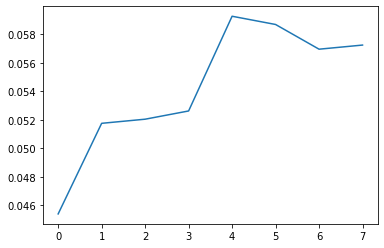

In [ ]:
plt.plot(AllHitrate)   ###Max == 50

In [ ]:
Vsvd_list = pureSVD(SVD_UserItemMAT,k=50)
print(len(Vsvd_list))

15


In [ ]:
Vsvd_last = Vsvd_list[-1]
Vsvd_last

array([[-5.21093989e-03, -1.43997794e-03,  8.24085211e-04, ...,
        -8.84044305e-03, -7.85443608e-03, -4.24750457e-03],
       [-2.31463216e-01, -3.18206357e-02, -4.90215540e-02, ...,
         6.41414572e-02,  5.63991071e-02, -9.01850235e-02],
       [ 1.38939582e-02,  1.48931262e-02,  1.71452752e-03, ...,
         6.33829077e-03,  4.59954168e-03, -1.85764305e-02],
       ...,
       [ 1.15398630e-05, -1.10198082e-04, -4.03091186e-05, ...,
        -7.91126412e-07,  2.37334984e-05, -6.28646908e-06],
       [ 1.15398630e-05, -1.10198082e-04, -4.03091186e-05, ...,
        -7.91126412e-07,  2.37334984e-05, -6.28646908e-06],
       [ 1.15398630e-05, -1.10198082e-04, -4.03091186e-05, ...,
        -7.91126412e-07,  2.37334984e-05, -6.28646908e-06]])

### SVD AllPred

In [ ]:
AllUsersSVD_PRED =  TQDMgetALLTopNPred_ALLUSERS(SVD_UserItemMAT,Vsvd_list, N=10) 
print(len(AllUsersSVD_PRED))
AllUsersSVD_PRED[:2]

15it [07:33, 30.24s/it]15



[array([[   17,   108,  1072, ...,  1108,    89,  1215],
        [  663,  1062,   969, ...,   267,   719,  1107],
        [ 1300,   108,    90, ...,    50,   318,   678],
        ...,
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719]]),
 array([[   17,   108,  1072, ...,  1108,    89,  1215],
        [  663,  1062,   969, ...,   267,   719,  1107],
        [ 1300,   108,    90, ...,    50,   318,   213],
        ...,
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719],
        [ 6918,  6901,  6908, ...,  6903,  6902, 20719]])]

In [ ]:
with open('MLDF20M_SVD_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersSVD_PRED, f)


## RandRec AllPred

In [ ]:
print(len(SVD_UserItemMAT),len(newHOLDOUT_LIST))

15 15


In [ ]:
All_UsersRRecPred = get_ALLRandPred(SVD_UserItemMAT,'Updated_UserID',N=10)
All_UsersRRecPred[:2]  

100%|██████████| 15/15 [15:04<00:00, 60.33s/it]


[array([[10399,  9457, 10652, ..., 20293,  9969, 13074],
        [17381,  9187, 19470, ..., 14438,  6737,  1733],
        [ 1731,  9052,  7557, ..., 12049, 13872,  9385],
        ...,
        [ 6374,  1653,   274, ..., 11490,  2060, 19305],
        [17965,  1419, 12976, ...,  9405, 14280,  4617],
        [17993, 15722,  5623, ..., 10584,  5186, 20247]]),
 array([[ 7497, 10920, 17390, ...,  1635, 18499, 10468],
        [10507, 15677,  3154, ...,  3331, 16174,  4025],
        [ 5266, 14584,  6137, ..., 14818,  7548,  1695],
        ...,
        [18879,  6476,  5348, ...,  4450, 12138,  8014],
        [ 8858,  8683, 15085, ..., 19253,  4969,   121],
        [ 5690, 14254,   503, ..., 19807,  4225, 17752]])]

In [ ]:
All_UsersRRecPred[1].shape

(136677, 10)

In [ ]:
with open('MLDF20M_RRec_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_UsersRRecPred, f)


## MostPop AllPred

In [ ]:
                      #getAll_MOSTPOP_Pred(DF_list,user_column,item_colum,Nusers,N
Nusers = newMLDF_20M['Updated_UserID'].nunique()
All_MostPOPRED_List =  getAll_MOSTPOP_Pred(new_PSIDFlist,'Updated_UserID','Updated_ItemID',Nusers,N=10)
All_MostPOPRED_List[:2]

[array([[13086,  2770,    78, ...,    92,  6760,  5632],
        [13086,  2770,    78, ...,    92,  6760,  5632],
        [13086,  2770,    78, ...,    92,  6760,  5632],
        ...,
        [13086,  2770,    78, ...,    92,  6760,  5632],
        [13086,  2770,    78, ...,    92,  6760,  5632],
        [13086,  2770,    78, ...,    92,  6760,  5632]]),
 array([[13086,  2770,    76, ...,  4750,  6760,  5632],
        [13086,  2770,    76, ...,  4750,  6760,  5632],
        [13086,  2770,    76, ...,  4750,  6760,  5632],
        ...,
        [13086,  2770,    76, ...,  4750,  6760,  5632],
        [13086,  2770,    76, ...,  4750,  6760,  5632],
        [13086,  2770,    76, ...,  4750,  6760,  5632]])]

In [ ]:
All_MostPOPRED_List[1].shape

(136677, 10)

In [ ]:
with open('MLDF20M_MPop_allPRED.pkl', 'wb') as f:
     pickle.dump(All_MostPOPRED_List, f)


# HitRate

### Updated PSI

In [ ]:
Top_NPred = TopNPred(UserItem_Matupdt[0],newHOLDOUT_LIST[0],V_1,'Updated_UserID',10)
Top_NPred

array([[2560, 1072, 4744, ..., 3041,  829, 3815],
       [ 980, 2250, 4652, ..., 1624, 4061, 1911],
       [2180,  532, 9037, ...,  144, 1466, 1066],
       ...,
       [ 180,  179, 1923, ...,  352,  781,  869],
       [1109,  144, 1115, ..., 2501, 1460, 1630],
       [2469, 1460,  157, ..., 2340, 2630, 2502]])

In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_UserID','Updated_ItemID')

Number of hits:  185
Total Num of users:  3459
Recommendation HitRate:  0.05348366579936398


0.05348366579936398

In [ ]:
AllUpdt_pred =  TQDMgetALLTopNPred(UserItem_Matupdt,newHOLDOUT_LIST,Vpsi_listUpdt,'Updated_UserID',N = 10)
print(len(AllUpdt_pred))
AllUpdt_pred[:2]

15it [00:11,  1.31it/s]15



[array([[2560, 1072, 4744, ..., 3041,  829, 3815],
        [ 980, 2250, 4652, ..., 1624, 4061, 1911],
        [2180,  532, 9037, ...,  144, 1466, 1066],
        ...,
        [ 180,  179, 1923, ...,  352,  781,  869],
        [1109,  144, 1115, ..., 2501, 1460, 1630],
        [2469, 1460,  157, ..., 2340, 2630, 2502]]),
 array([[2560, 1072, 4744, ..., 3041, 9331, 8837],
        [ 980, 2250, 4652, ..., 1624, 4061, 1911],
        [1300,  603, 1086, ..., 2560,  267,  663],
        ...,
        [2707,  969, 1763, ..., 1319, 4724, 2008],
        [1829, 1055, 2770, ..., 1070, 1807, 4080],
        [4724, 8837, 8928, ..., 8958, 4032, 9331]])]

In [ ]:
AllSteps_HitR_updt, LowerBand_updt, Avg_HitR_updt, UpperBand_updt   = getAll_HitRate(newHOLDOUT_LIST,AllUpdt_pred,'Updated_UserID','Updated_ItemID')
AllSteps_HitR_updt

Number of hits:  185
Total Num of users:  3459
Recommendation HitRate:  0.05348366579936398
Number of hits:  160
Total Num of users:  3311
Recommendation HitRate:  0.048323769254001815
Number of hits:  163
Total Num of users:  3124
Recommendation HitRate:  0.052176696542893725
Number of hits:  160
Total Num of users:  3115
Recommendation HitRate:  0.051364365971107544
Number of hits:  173
Total Num of users:  3165
Recommendation HitRate:  0.05466034755134281
Number of hits:  154
Total Num of users:  3098
Recommendation HitRate:  0.04970948999354422
Number of hits:  136
Total Num of users:  3169
Recommendation HitRate:  0.04291574629220574
Number of hits:  168
Total Num of users:  3129
Recommendation HitRate:  0.053691275167785234
Number of hits:  186
Total Num of users:  3192
Recommendation HitRate:  0.05827067669172932
Number of hits:  183
Total Num of users:  3409
Recommendation HitRate:  0.05368143150484013
Number of hits:  182
Total Num of users:  3267
Recommendation HitRate:  0.05

[0.05348366579936398,
 0.048323769254001815,
 0.052176696542893725,
 0.051364365971107544,
 0.05466034755134281,
 0.04970948999354422,
 0.04291574629220574,
 0.053691275167785234,
 0.05827067669172932,
 0.05368143150484013,
 0.05570860116314662,
 0.05037374065648359,
 0.05952380952380952,
 0.05370650529500756,
 0.05860805860805861]

In [ ]:
print(LowerBand_updt)
print(UpperBand_updt)
print(Avg_HitR_updt)

0.05070211425418469
0.05545764308119137
0.05307987866768803


### Regular PSI

In [ ]:
Top10Pred_psi = TopNPred(UserItemMAT_regPSI[0], newHOLDOUT_LIST[0],Vpsi_listReg[0],'Updated_UserID',N=10)
print(Top10Pred_psi.shape)

(3459, 10)


In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_UserID','Updated_ItemID')

Number of hits:  183
Total Num of users:  3459
Recommendation HitRate:  0.05290546400693842


0.05290546400693842

In [ ]:
All_regPSI_PRED =  TQDMgetALLTopNPred(UserItemMAT_regPSI,newHOLDOUT_LIST,Vpsi_listReg,'Updated_UserID',N = 10)
print(len(All_regPSI_PRED))
All_regPSI_PRED[:2]

15it [00:10,  1.42it/s]15



[array([[2560, 1072, 4744, ..., 3041,  829, 3815],
        [ 980, 2250, 4652, ..., 1624, 4061, 1911],
        [2180,  532, 9037, ...,  144, 1466, 1066],
        ...,
        [ 180,  179, 1923, ...,  352,  781,  869],
        [1109,  144, 1115, ..., 2501, 1460, 1630],
        [2469, 1460,  157, ..., 2340, 2630, 2502]]),
 array([[2560, 1072, 4744, ..., 3041, 9331, 8837],
        [ 980, 2250, 4652, ..., 1624, 4061, 1911],
        [1300,  603, 1086, ..., 2560,  267,  663],
        ...,
        [2707,  969, 1763, ..., 1319, 4724, 2008],
        [1829, 1055, 2770, ..., 1070, 4080, 1807],
        [4724, 8837, 8928, ..., 8958, 4032, 4652]])]

In [ ]:
AllSteps_Hitrate_psi, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_UserID','Updated_ItemID')
AllSteps_Hitrate_psi

Number of hits:  183
Total Num of users:  3459
Recommendation HitRate:  0.05290546400693842
Number of hits:  160
Total Num of users:  3311
Recommendation HitRate:  0.048323769254001815
Number of hits:  163
Total Num of users:  3124
Recommendation HitRate:  0.052176696542893725
Number of hits:  164
Total Num of users:  3115
Recommendation HitRate:  0.05264847512038523
Number of hits:  173
Total Num of users:  3165
Recommendation HitRate:  0.05466034755134281
Number of hits:  152
Total Num of users:  3098
Recommendation HitRate:  0.04906391220142027
Number of hits:  140
Total Num of users:  3169
Recommendation HitRate:  0.044177974124329444
Number of hits:  167
Total Num of users:  3129
Recommendation HitRate:  0.05337168424416747
Number of hits:  187
Total Num of users:  3192
Recommendation HitRate:  0.05858395989974937
Number of hits:  182
Total Num of users:  3409
Recommendation HitRate:  0.053388090349075976
Number of hits:  181
Total Num of users:  3267
Recommendation HitRate:  0.05

[0.05290546400693842,
 0.048323769254001815,
 0.052176696542893725,
 0.05264847512038523,
 0.05466034755134281,
 0.04906391220142027,
 0.044177974124329444,
 0.05337168424416747,
 0.05858395989974937,
 0.053388090349075976,
 0.055402509947964494,
 0.05004874878128047,
 0.05988455988455989,
 0.054084720121028745,
 0.05934065934065934]

In [ ]:
print(LowerBand, Avg_HitRate, UpperBand)

0.05085060616484444 0.053204104757986495 0.05555760335112855


### SVD HItR_

In [ ]:
Top10Pred_SVD = TopNPred(SVD_UserItemMAT[0],newHOLDOUT_LIST[0],Vsvd_list[0],'Updated_UserID',N=10)
print(Top10Pred_SVD.shape)
Top10Pred_SVD

(3459, 10)


array([[4744, 2560, 1072, ..., 1069, 1070,  829],
       [ 980, 4652, 2250, ..., 4061, 1624, 1911],
       [2180,  532, 6381, ..., 1466, 3407,    1],
       ...,
       [ 180,  352,  179, ..., 1909,  969, 1917],
       [ 144, 1109, 1115, ..., 2542, 2501,  198],
       [2469, 1460,  157, ..., 2340, 2630, 2502]])

In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_UserID','Updated_ItemID')

Number of hits:  205
Total Num of users:  3459
Recommendation HitRate:  0.059265683723619546


0.059265683723619546

In [ ]:
AllSVD_topNPRED =  TQDMgetALLTopNPred(SVD_UserItemMAT,newHOLDOUT_LIST,Vsvd_list,'Updated_UserID',N = 10)
print(len(AllSVD_topNPRED))
AllSVD_topNPRED[:2]

15it [00:10,  1.44it/s]15



[array([[4744, 2560, 1072, ..., 1069, 1070,  829],
        [ 980, 4652, 2250, ..., 4061, 1624, 1911],
        [2180,  532, 6381, ..., 1466, 3407,    1],
        ...,
        [ 180,  352,  179, ..., 1909,  969, 1917],
        [ 144, 1109, 1115, ..., 2542, 2501,  198],
        [2469, 1460,  157, ..., 2340, 2630, 2502]]),
 array([[ 4744,  1072,  2560, ...,  9331,  1069,  8837],
        [  980,  4652,  2250, ...,  4061,  1624,  1911],
        [ 1300,  1086,   603, ...,   267,   663,  3220],
        ...,
        [ 2707,   969,  1763, ...,  2543,  1319,  1126],
        [ 1829,  1055,  2770, ...,  1070,  4080,    59],
        [ 4724,  9761,  8837, ...,  9695, 11965,  8958]])]

In [ ]:
AllSteps_Hitrate_svd, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_UserID','Updated_ItemID')

Number of hits:  205
Total Num of users:  3459
Recommendation HitRate:  0.059265683723619546
Number of hits:  165
Total Num of users:  3311
Recommendation HitRate:  0.04983388704318937
Number of hits:  169
Total Num of users:  3124
Recommendation HitRate:  0.05409731113956466
Number of hits:  182
Total Num of users:  3115
Recommendation HitRate:  0.058426966292134834
Number of hits:  182
Total Num of users:  3165
Recommendation HitRate:  0.05750394944707741
Number of hits:  154
Total Num of users:  3098
Recommendation HitRate:  0.04970948999354422
Number of hits:  147
Total Num of users:  3169
Recommendation HitRate:  0.04638687283054591
Number of hits:  180
Total Num of users:  3129
Recommendation HitRate:  0.05752636625119847
Number of hits:  195
Total Num of users:  3192
Recommendation HitRate:  0.06109022556390977
Number of hits:  187
Total Num of users:  3409
Recommendation HitRate:  0.054854796127896746
Number of hits:  198
Total Num of users:  3267
Recommendation HitRate:  0.060

In [ ]:
AllSteps_Hitrate_svd

[0.059265683723619546,
 0.04983388704318937,
 0.05409731113956466,
 0.058426966292134834,
 0.05750394944707741,
 0.04970948999354422,
 0.04638687283054591,
 0.05752636625119847,
 0.06109022556390977,
 0.054854796127896746,
 0.06060606060606061,
 0.052973675658108545,
 0.06673881673881674,
 0.05937972768532526,
 0.06263736263736264]

In [ ]:
 print(LowerBand, Avg_HitRate, UpperBand) 

0.05372014044420813 0.05673541278255698 0.05975068512090584


### RRec HitR_

### MPop HitR_

In [ ]:
RRec_AllStepsHitR, RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR = getAll_RandomHitRate(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')

Number of hits:  1
Total Num of users:  3459
Recommendation HitRate:  0.0002891008962127783
Number of hits:  2
Total Num of users:  3311
Recommendation HitRate:  0.0006040471156750226
Number of hits:  2
Total Num of users:  3124
Recommendation HitRate:  0.0006402048655569782
Number of hits:  0
Total Num of users:  3115
Recommendation HitRate:  0.0
Number of hits:  1
Total Num of users:  3165
Recommendation HitRate:  0.000315955766192733
Number of hits:  2
Total Num of users:  3098
Recommendation HitRate:  0.0006455777921239509
Number of hits:  4
Total Num of users:  3169
Recommendation HitRate:  0.0012622278321236984
Number of hits:  1
Total Num of users:  3129
Recommendation HitRate:  0.00031959092361776926
Number of hits:  2
Total Num of users:  3192
Recommendation HitRate:  0.0006265664160401002
Number of hits:  3
Total Num of users:  3409
Recommendation HitRate:  0.0008800234672924611
Number of hits:  0
Total Num of users:  3267
Recommendation HitRate:  0.0
Number of hits:  1
Total

In [ ]:
RRec_AllStepsHitR

[0.0002891008962127783,
 0.0006040471156750226,
 0.0006402048655569782,
 0.0,
 0.000315955766192733,
 0.0006455777921239509,
 0.0012622278321236984,
 0.00031959092361776926,
 0.0006265664160401002,
 0.0008800234672924611,
 0.0,
 0.00032499187520311994,
 0.00036075036075036075,
 0.0007564296520423601,
 0.001098901098901099]

In [ ]:
print( RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR)

0.000340182505375665 0.0005416245374488288 0.0007430665695219926


In [ ]:
##MOSTPOP

In [ ]:
AllSteps_Hitrate, LowerBand, Avg_HitRate, UpperBand  = getAll_MostPOPHitRate(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')

Number of hits:  98
Total Num of users:  3459
Recommendation HitRate:  0.028331887828852268
Number of hits:  68
Total Num of users:  3311
Recommendation HitRate:  0.02053760193295077
Number of hits:  70
Total Num of users:  3124
Recommendation HitRate:  0.02240717029449424
Number of hits:  105
Total Num of users:  3115
Recommendation HitRate:  0.033707865168539325
Number of hits:  157
Total Num of users:  3165
Recommendation HitRate:  0.04960505529225909
Number of hits:  144
Total Num of users:  3098
Recommendation HitRate:  0.046481601032924466
Number of hits:  158
Total Num of users:  3169
Recommendation HitRate:  0.04985799936888608
Number of hits:  106
Total Num of users:  3129
Recommendation HitRate:  0.03387663790348354
Number of hits:  108
Total Num of users:  3192
Recommendation HitRate:  0.03383458646616541
Number of hits:  164
Total Num of users:  3409
Recommendation HitRate:  0.04810794954532121
Number of hits:  114
Total Num of users:  3267
Recommendation HitRate:  0.034894

In [ ]:
AllSteps_Hitrate

[0.028331887828852268,
 0.02053760193295077,
 0.02240717029449424,
 0.033707865168539325,
 0.04960505529225909,
 0.046481601032924466,
 0.04985799936888608,
 0.03387663790348354,
 0.03383458646616541,
 0.04810794954532121,
 0.03489439853076217,
 0.03899902502437439,
 0.027056277056277056,
 0.044251134644478066,
 0.041758241758241756]

In [ ]:
print(LowerBand, Avg_HitRate, UpperBand)

0.03155772898046011 0.03691382878986733 0.042269928599274545


# MRR_Scores

### Updated_mrr

In [ ]:
mrr_1st = MRR_Eval(newHOLDOUT_LIST[0],Top_NPred,'Updated_ItemID')
print("1st Step MRR: ",mrr_1st)

1st Step MRR:  0.01975006539186938


In [ ]:
AllSteps_MRRUpdt, LowerB_Updt, AvgMRR_Updt, UpperB_Updt  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllUpdt_pred,'Updated_ItemID')
AllSteps_MRRUpdt    

15it [00:00, 570.76it/s]


[0.01975,
 0.019939,
 0.020556,
 0.023973,
 0.022273,
 0.018741,
 0.015228,
 0.020376,
 0.024525,
 0.020789,
 0.023081,
 0.019634,
 0.025079,
 0.021992,
 0.025983]

In [ ]:
print(LowerB_Updt, AvgMRR_Updt, UpperB_Updt)
print("Average MRR: ",AvgMRR_Updt)

0.019908 0.021461 0.023014
Average MRR:  0.021461


### RegPSI_MRR

In [ ]:
##MRR: 
mrr_psi_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_ItemID')
print("1st Step MRR: ",mrr_psi_1st)

1st Step MRR:  0.019661040671448304


In [ ]:
psi_AllStepsMRR, psi_LowerB, psi_AvgMRR, psi_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_ItemID')
psi_AllStepsMRR  


15it [00:00, 585.94it/s]


[0.019661,
 0.019737,
 0.020506,
 0.024115,
 0.022424,
 0.018706,
 0.015411,
 0.020189,
 0.024576,
 0.020357,
 0.023035,
 0.019458,
 0.025305,
 0.021488,
 0.026158]

In [ ]:
print(psi_LowerB, psi_AvgMRR, psi_UpperB)
print("Average MRR: ",psi_AvgMRR)

0.01982 0.021408 0.022996
Average MRR:  0.021408


### SVD_MRR

In [ ]:
##MRR: 
mrr_SVD_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_ItemID')
print("1st Step MRR: ",mrr_SVD_1st)

1st Step MRR:  0.021891477030245462


In [ ]:
svd_AllStepsMRR, svd_LowerB, svd_AvgMRR, svd_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_ItemID')
svd_AllStepsMRR  

15it [00:00, 593.52it/s]


[0.021891,
 0.020462,
 0.020787,
 0.026738,
 0.023202,
 0.019234,
 0.015943,
 0.020867,
 0.025518,
 0.02196,
 0.024627,
 0.020163,
 0.027391,
 0.023731,
 0.02687]

In [ ]:
 print(svd_LowerB, svd_AvgMRR, svd_UpperB )

0.020838 0.022626 0.024413


### RRec_MRR

In [ ]:
RRec_AllStepsMRR, RRec_LowB, RRec_Avg_MRR, RRec_UppB = getAll_RandomRecMRR(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')
RRec_AllStepsMRR

15it [00:00, 421.28it/s]


[2.9e-05,
 0.000136,
 0.000267,
 0,
 6.3e-05,
 0.000145,
 0.00051,
 5.3e-05,
 0.000107,
 0.000293,
 0,
 4.6e-05,
 3.6e-05,
 0.00018,
 0.000534]

In [ ]:
print(RRec_LowB, RRec_Avg_MRR, RRec_UppB )

6.480499621493013e-05 0.00015993333333333334 0.00025506167045173656


### Mpop_MRR

In [ ]:
#MRR....
                                    #getAll_MostPOP_MRR(HOLDOUT_list,All_MostPOPRED_List,user_column,item_column)
Mpop_AllStepsMRR, Mpop_LowB, Mpop_AvgMRR, Mpop_UppB = getAll_MostPOP_MRR(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')
Mpop_AllStepsMRR

15it [00:00, 408.52it/s]


[0.01098044209492605,
 0.008510112995162829,
 0.005915797817206269,
 0.01641162832174068,
 0.02132036911657765,
 0.012429934315021467,
 0.02729592731170516,
 0.009584937629041177,
 0.011028439153439156,
 0.010724296563252267,
 0.010729225880741034,
 0.008993634286126975,
 0.007528802766898005,
 0.0121273383281704,
 0.009541979184836328]

In [ ]:
print( Mpop_LowB, Mpop_AvgMRR, Mpop_UppB )

0.0091206955312628 0.012208191050989697 0.015295686570716595


# Coverage

### UpdtedPSI_COV

In [ ]:
StepCoverage_Ratio(newMLDF_20M,AllUsers_updtPRED[0],'Updated_ItemID')  

0.042278

In [ ]:
UpdtAvg_Coverage_List = AllSteps_Coverage_Ratio(newMLDF_20M,AllUsers_updtPRED,'Updated_ItemID')
UpdtAvg_Coverage_List

[0.042278,
 0.042326,
 0.042278,
 0.042278,
 0.042133,
 0.042181,
 0.042471,
 0.042471,
 0.042519,
 0.042471,
 0.042471,
 0.041988,
 0.042085,
 0.042085,
 0.042181]

###RegPSI_COV

In [ ]:
psi_AvgCoverage_List = AllSteps_Coverage_Ratio(newMLDF_20M,AllUsersRegPIS_PRED,'Updated_ItemID')
psi_AvgCoverage_List

[0.042326,
 0.042375,
 0.042326,
 0.042423,
 0.042568,
 0.042519,
 0.042664,
 0.042809,
 0.042761,
 0.042905,
 0.042857,
 0.043098,
 0.043243,
 0.04334,
 0.042905]

### SVD_COV


In [ ]:
SVD_AvgCoverage_List = AllSteps_Coverage_Ratio(newMLDF_20M,AllUsersSVD_PRED,'Updated_ItemID')
SVD_AvgCoverage_List

[0.043292,
 0.043147,
 0.043243,
 0.043243,
 0.043678,
 0.043822,
 0.044112,
 0.044208,
 0.044112,
 0.044402,
 0.044788,
 0.045077,
 0.04527,
 0.04527,
 0.044643]

### RRec_COV

In [ ]:
##COVERAGE
RRec_AvgCoverageList = AllSteps_Coverage_Ratio(newMLDF_20M,All_UsersRRecPred,'Updated_ItemID')
RRec_AvgCoverageList

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### Mpop_COV

In [ ]:
##COVERAGE
MPop_AvgCoverageList = AllSteps_Coverage_Ratio(newMLDF_20M,All_MostPOPRED_List,'Updated_ItemID')
MPop_AvgCoverageList

[0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483,
 0.000483]

# Stability

In [ ]:
AllSteps = list(range(1,15))
print(len(AllSteps))
print(len(AllUsers_updtPRED))
AllSteps

14
15


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

####  Updated_Corr 

In [ ]:
#newHOLDOUT_LIST  newUserItem_list new_PSIDFlist newMLDF_1M

In [ ]:
UpdtPSICorr_ = Updt_getAll_AvgCorr(AllUsers_updtPRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
UpdtPSICorr_

array([array([1.        , 1.        , 1.        , ..., 0.        , 0.5327588 ,
              0.92942099])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 0.88483146,
              0.93397092])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.37435993, 1.        ,
              0.22080715])                                                    ,
       array([1., 1., 1., ..., 0., 0., 0.]),
       array([1.        , 0.98788042, 1.        , ..., 0.14186262, 0.47797357,
              0.25762481])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.12326891, 0.97749498,
              0.        ])                                                    ,
       array([1.        , 0.99244163, 1.        , ..., 0.74656886, 0.97010543,
              0.42311771])                                                    ,
 

In [ ]:
UpdtPSICorr_.shape
for df in UpdtPSICorr_:
    print(df.mean())  

0.9869968716072547
0.9868989972464394
0.9865945505051228
0.9867358455398915
0.9870913236773649
0.9873940193396127
0.9861379816431397
0.9847879831721422
0.9859487909279454
0.9857501791677638
0.9862889000073568
0.9861786579017224
0.9869899653239385
0.9867127416063536


#### RegPSI Corr_

In [ ]:
RegPSICorr_ = Updt_getAll_AvgCorr(AllUsersRegPIS_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
RegPSICorr_

array([array([1.        , 1.        , 1.        , ..., 0.        , 0.5327588 ,
              0.92942099])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 0.88483146,
              0.99244163])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.37435993, 0.94467132,
              0.22080715])                                                    ,
       array([1.        , 0.99244163, 1.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.14933043, 0.47384185,
              0.25762481])                                                    ,
       array([1.        , 0.98788042, 1.        , ..., 0.12326891, 0.97749498,
              0.        ])                                                    ,
       array([1.        , 1.        , 1.      

In [ ]:
RegPSICorr_.shape
for df in RegPSICorr_:
    print(df.mean())  

0.9855048062717018
0.9861018386404111
0.9852377038892418
0.9857303673077384
0.9862022524456981
0.9866724545432374
0.9854086006170346
0.9847044408034471
0.9852414145782077
0.9852197279323629
0.9858297502108592
0.9850812223405825
0.9861475520293389
0.9863765964344147


#### SVD Corr_

In [ ]:
pureSVDCorr_ = Updt_getAll_AvgCorr(AllUsersSVD_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
pureSVDCorr_

array([array([1.        , 1.        , 0.9188873 , ..., 0.        , 0.52326901,
              0.9526455 ])                                                    ,
       array([1.        , 1.        , 0.94287971, ..., 0.96643133, 0.91739187,
              0.93397092])                                                    ,
       array([1.        , 1.        , 0.9188873 , ..., 0.40176621, 1.        ,
              0.26897619])                                                    ,
       array([0.88386932, 1.        , 1.        , ..., 0.        , 0.        ,
              0.01933435])                                                    ,
       array([1.        , 0.99056095, 0.82833787, ..., 0.12661223, 0.46768741,
              0.20792079])                                                    ,
       array([1.        , 1.        , 0.98788042, ..., 0.1898122 , 0.93473132,
              0.        ])                                                    ,
       array([1.        , 1.        , 0.966431

In [ ]:
pureSVDCorr_.shape
for df in pureSVDCorr_:
    print(df.mean())  

0.9579424284625256
0.965364936075921
0.9642275983258505
0.9608110874077603
0.953990420958191
0.9599172349005631
0.9566948972961938
0.9513547931345175
0.9524740479592377
0.9549345307900835
0.9570971666956241
0.9560427963904784
0.9606629440666354
0.9639037143474501


### RRec_Corr 

In [ ]:
RandRec_Corr = Updt_getAll_AvgCorr(All_UsersRRecPred,newUserItem_list,AllSteps,'Updated_UserID')  #,
RandRec_Corr

array([array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [ ]:
RandRec_Corr.shape
for df in RandRec_Corr:
    print(df.mean())  

0.00014943053005383439
0.00014655634827379167
0.00016311911918226105
0.00015405213865251005
0.0001428826447486091
0.00015048594727601791
0.00015796929672729035
0.00015671588665702664
0.00014516019575147408
0.00016528054798944014
0.00015321439168188263
0.0001413929288347257
0.00014559461697162025
0.00014997510393781067


### Mpop_Corr 

In [ ]:
MPop_Corr = Updt_getAll_AvgCorr(All_MostPOPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
MPop_Corr

array([array([0.88146826, 0.88146826, 0.88146826, ..., 0.88146826, 0.88146826,
              0.88146826])                                                    ,
       array([0.39435156, 0.39435156, 0.39435156, ..., 0.39435156, 0.39435156,
              0.39435156])                                                    ,
       array([0.47017229, 0.47017229, 0.47017229, ..., 0.47017229, 0.47017229,
              0.47017229])                                                    ,
       array([0.39382495, 0.39382495, 0.39382495, ..., 0.39382495, 0.39382495,
              0.39382495])                                                    ,
       array([0.44146079, 0.44146079, 0.44146079, ..., 0.44146079, 0.44146079,
              0.44146079])                                                    ,
       array([0.45095341, 0.45095341, 0.45095341, ..., 0.45095341, 0.45095341,
              0.45095341])                                                    ,
       array([0.43851101, 0.43851101, 0.438511

In [ ]:
MPop_Corr.shape
for df in MPop_Corr:
    print(df.mean())  

0.8814682640836098
0.39435156323793324
0.4701722935962555
0.39382494570862053
0.44146079484425366
0.45095341065461
0.43851101149873295
0.6554895144106763
0.7634691195795007
0.700103650811931
0.7708733205374277
0.5519343986543311
0.4021656534954409
0.5709268915611362
